## todo


- add cm
- add xgboost to custom.json
- add cleaning
- add t-SNE
- add other datasets
- - iris, moon, blobs


In [1]:
%matplotlib inline

import matplotlib

import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons





In [2]:
%load_ext autoreload
%autoreload 2
packages = !conda list
packages

['# packages in environment at /opt/conda:',
 '#',
 '# Name                    Version                   Build  Channel',
 '_libgcc_mutex             0.1                 conda_forge    conda-forge',
 '_openmp_mutex             4.5                       0_gnu    conda-forge',
 'alembic                   1.4.2              pyh9f0ad1d_0    conda-forge',
 'astroid                   2.4.1                    pypi_0    pypi',
 'astunparse                1.6.3                    pypi_0    pypi',
 'async_generator           1.10                       py_0    conda-forge',
 'attrs                     19.3.0                     py_0    conda-forge',
 'backcall                  0.1.0                      py_0    conda-forge',
 'bleach                    3.1.4              pyh9f0ad1d_0    conda-forge',
 'blinker                   1.4                        py_1    conda-forge',
 'brotlipy                  0.7.0           py37h8f50634_1000    conda-forge',
 'ca-certificates           2020.4.5.1     

In [3]:
!pwd


/docker/photon_experiments


## Output registry

In [4]:
from __future__ import print_function
import sys, os

old__file__ = !pwd
__file__ = !cd ../photon ;pwd
#__file__ = !pwd
__file__ = __file__[0]
__file__
sys.path.append(__file__)
print(sys.path)
os.chdir(old__file__[0])
!pwd
old__file__[0]

['/docker/photon_experiments', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/home/jovyan/.ipython', '/docker/photon']
/docker/photon_experiments


'/docker/photon_experiments'

In [5]:

import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import itertools


from clusim.clustering import Clustering, remap2match
import clusim.sim as sim

from photonai.base import Hyperpipe, PipelineElement, Preprocessing, OutputSettings
from photonai.optimization import FloatRange, Categorical, IntegerRange
from photonai.base.photon_elements import PhotonRegistry
from photonai.visual.graphics import plot_cm
#from photonai.base.registry.registry import PhotonRegistry

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [6]:
#import pixiedust


In [7]:
def results_to_df(results):
    ll = []
    for obj in results:
        ll.append([obj.operation,
        obj.value,
        obj.metric_name])
    _results=pd.DataFrame(ll).pivot(index=2, columns=0, values=1)
    _results.columns=['Mean','STD']
    
    return(_results)

In [8]:
__file__ = "exp1.log"
base_folder = os.path.dirname(os.path.abspath(''))
custom_elements_folder = os.path.join(base_folder, 'custom_elements')
custom_elements_folder

'/docker/custom_elements'

In [9]:
registry = PhotonRegistry(custom_elements_folder=custom_elements_folder)
registry.activate()
registry.PHOTON_REGISTRIES,PhotonRegistry.PHOTON_REGISTRIES

(['PhotonCore', 'PhotonCluster', 'PhotonNeuro', 'CustomElements'],
 ['PhotonCore', 'PhotonCluster', 'PhotonNeuro', 'CustomElements'])

In [10]:
registry.activate()
registry.list_available_elements()
# take off last name


PhotonCore
ARDRegression                       sklearn.linear_model.ARDRegression                                          Estimator
AdaBoostClassifier                  sklearn.ensemble.AdaBoostClassifier                                         Estimator
AdaBoostRegressor                   sklearn.ensemble.AdaBoostRegressor                                          Estimator
BaggingClassifier                   sklearn.ensemble.BaggingClassifier                                          Estimator
BaggingRegressor                    sklearn.ensemble.BaggingRegressor                                           Estimator
BayesianGaussianMixture             sklearn.mixture.BayesianGaussianMixture                                     Estimator
BayesianRidge                       sklearn.linear_model.BayesianRidge                                          Estimator
BernoulliNB                         sklearn.naive_bayes.BernoulliNB                                             Estimator
BernoulliRBM

## KMeans blobs

In [11]:
CLUSTER_ALGO = 'KMedoids'
registry.info(CLUSTER_ALGO)

----------------------------------
Name: KMedoids
Namespace: sklearn_extra.cluster
----------------------------------
Possible Hyperparameters as derived from constructor:
n_clusters                          n_clusters=8                                                               
metric                              metric='euclidean'                                                         
init                                init='heuristic'                                                           
max_iter                            max_iter=300                                                               
random_state                        random_state=None                                                          
----------------------------------


('KMedoids',
 'sklearn_extra.cluster',
 {'n_clusters': 'n_clusters',
  'metric': 'metric',
  'init': 'init',
  'max_iter': 'max_iter',
  'random_state': 'random_state'})

In [12]:
import sklearn.datasets as skd
NC = 3
def yield_parameters(n_p_clusters):
    n_cluster = NC
    cluster_std = 1.0
    for n_p_cluster in n_p_clusters:
        n_cluster_std = [cluster_std for k in range(n_cluster)]
        n_samples = [n_p_cluster for k in range(n_cluster)]
        data_X, data_y = skd.make_blobs(n_samples=n_samples,
                                   cluster_std=n_cluster_std, random_state=0)
        yield [data_X, data_y]

In [13]:
#import pixiedust
#%%pixie_debugger

In [14]:
def hyper_cluster(cluster_name):
    
    n_p_clusters = [3,30, 100, 300, 3000]

    for data_X, data_y  in yield_parameters(n_p_clusters):
        print('n_points:', len(data_y))
        """
        Example script for KMedoids hopt
        """
        X = data_X.copy(); y =  data_y.copy()
        # DESIGN YOUR PIPELINE
        settings = OutputSettings(project_folder='./tmp/')

        my_pipe = Hyperpipe('batching',
                            optimizer='sk_opt',
        #                    optimizer_params={'n_configurations': 25},
                            metrics=['ARI', 'MI', 'HCV', 'FM'],
                            best_config_metric='ARI',
                            outer_cv=KFold(n_splits=NC),
                            inner_cv=KFold(n_splits=NC),
                            verbosity=0,
                            output_settings=settings)


        my_pipe += PipelineElement(cluster_name
                                   , hyperparameters={
                                       'n_clusters': IntegerRange(2, NC),
                                   },random_state=777)

        # NOW TRAIN YOUR PIPELINE
        my_pipe.fit(X, y)

        debug = True
    #------------------------------plot
        y_pred= my_pipe.predict(X)
        colors = 'BuPu'
        fig = plt.figure(figsize=(8,8))
        plt.scatter(X[:, 0], X[:, 1], s=50, c=y_pred
                    ,cmap=colors )
        plt.show()
    #--------------------------------- best
        print(pd.DataFrame(my_pipe.best_config.items()
                           ,columns=['n_clusters', 'k']))
    #------------------------------
        print('train','\n'
              ,results_to_df(my_pipe.results.metrics_train))
        print('test','\n'
              ,results_to_df(my_pipe.results.metrics_test))
    #------------------------------   
        # turn the ground-truth labels into a clusim Clustering
        true_clustering = Clustering().from_membership_list(y) 
        kmeans_clustering = Clustering().from_membership_list(y_pred) # lets see how similar the predicted k-means clustering is to the true clustering
    #------------------------------
        # using all available similar measures!
        row_format2 ="{:>25}" * (2)
        for simfunc in sim.available_similarity_measures:
            print(row_format2.format(simfunc, eval('sim.' + simfunc+'(true_clustering, kmeans_clustering)')))
    #------------------------------# The element-centric similarity is particularly useful for understanding
    # how a clustering method performed

    # Let's start with the single similarity value:
        elsim = sim.element_sim(true_clustering, kmeans_clustering)
        print("Element-centric similarity: {}".format(elsim))

n_points: 9
***************************************************************************************************************
PHOTON ANALYSIS: batching
***************************************************************************************************************

***************************************************************************************************************
Outer Cross validation Fold 1
***************************************************************************************************************
---------------------------------------------------------------------------------------------------------------
BEST_CONFIG 
---------------------------------------------------------------------------------------------------------------
{
    "KMedoids": [
        "n_clusters=3"
    ]
}
+--------+-------------------+------------------+
| METRIC | PERFORMANCE TRAIN | PERFORMANCE TEST |
+--------+-------------------+------------------+
|  ARI   |       1.0000      |      1.0000   

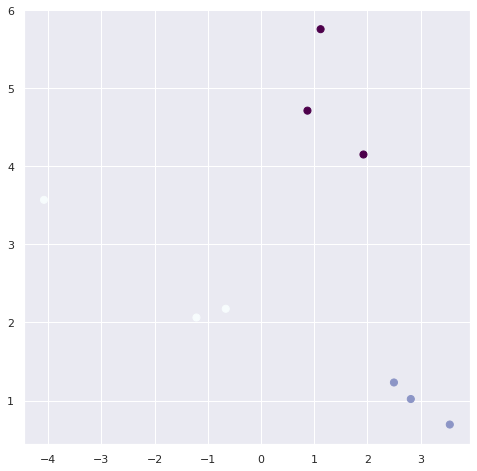

             n_clusters  k
0  KMedoids__n_clusters  3
train 
      Mean  STD
2             
ARI   1.0  0.0
FM    1.0  0.0
HCV   1.0  0.0
MI    1.0  0.0
test 
      Mean  STD
2             
ARI   1.0  0.0
FM    0.0  0.0
HCV   1.0  0.0
MI    1.0  0.0
            jaccard_index                      1.0
               rand_index                      1.0
            adjrand_index                      1.0
    fowlkes_mallows_index                      1.0
                 fmeasure                      1.0
             purity_index                      1.0
     classification_error                      0.0
        czekanowski_index                      1.0
               dice_index                      1.0
           sorensen_index                      1.0
    rogers_tanimoto_index                      1.0
          southwood_index                      1.0
      pearson_correlation      0.00411522633744856
         corrected_chance                      1.0
      sample_expected_sim            

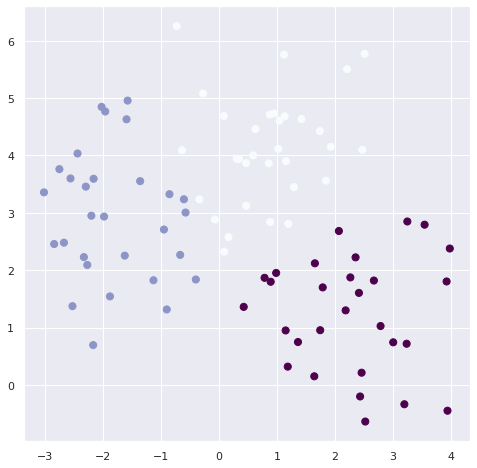

             n_clusters  k
0  KMedoids__n_clusters  3
train 
          Mean       STD
2                      
ARI  0.816280  0.059494
FM   0.877682  0.039908
HCV  0.787622  0.075900
MI   0.782138  0.079336
test 
          Mean       STD
2                      
ARI  0.716614  0.056834
FM   0.817438  0.030705
HCV  0.744294  0.057265
MI   0.713823  0.072192
            jaccard_index       0.7691266079891672
               rand_index        0.914856429463171
            adjrand_index       0.8063155341974434
    fowlkes_mallows_index       0.8694992336073233
                 fmeasure       0.8694986605434366
             purity_index       0.9333333333333333
     classification_error      0.06666666666666665
        czekanowski_index       0.8694986605434366
               dice_index       0.8694986605434366
           sorensen_index       0.8694986605434366
    rogers_tanimoto_index       0.8430740911182697
          southwood_index       3.3313782991202348
      pearson_correlation   2.2

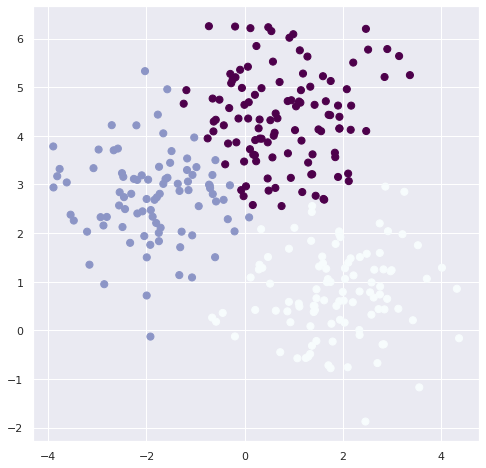

             n_clusters  k
0  KMedoids__n_clusters  3
train 
          Mean       STD
2                      
ARI  0.762640  0.038063
FM   0.841290  0.025317
HCV  0.704914  0.034628
MI   0.703102  0.034493
test 
          Mean       STD
2                      
ARI  0.773923  0.074848
FM   0.848079  0.050396
HCV  0.735840  0.089091
MI   0.731250  0.090609
            jaccard_index       0.7304615027829313
               rand_index       0.8963433667781494
            adjrand_index       0.7665681418850896
    fowlkes_mallows_index       0.8442491914375327
                 fmeasure       0.8442389519884745
             purity_index       0.9166666666666667
     classification_error      0.08333333333333326
        czekanowski_index       0.8442389519884745
               dice_index       0.8442389519884745
           sorensen_index       0.8442389519884745
    rogers_tanimoto_index       0.8121578213701287
          southwood_index       2.7100451710045173
      pearson_correlation   1.7

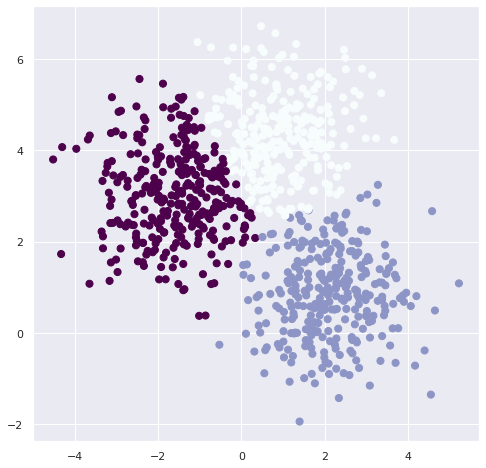

             n_clusters  k
0  KMedoids__n_clusters  3
train 
          Mean       STD
2                      
ARI  0.801861  0.008822
FM   0.867743  0.005892
HCV  0.751050  0.007657
MI   0.750395  0.007721
test 
          Mean       STD
2                      
ARI  0.803466  0.015436
FM   0.868692  0.010405
HCV  0.752457  0.014140
MI   0.751024  0.014369
            jaccard_index       0.7636836451291725
               rand_index       0.9108219008775182
            adjrand_index       0.7991818678615374
    fowlkes_mallows_index       0.8660099188793733
                 fmeasure       0.8660097826934718
             purity_index       0.9277777777777778
     classification_error      0.07222222222222219
        czekanowski_index       0.8660097826934718
               dice_index       0.8660097826934718
           sorensen_index       0.8660097826934718
    rogers_tanimoto_index       0.8362469844108509
          southwood_index        3.231615710840702
      pearson_correlation   2.1

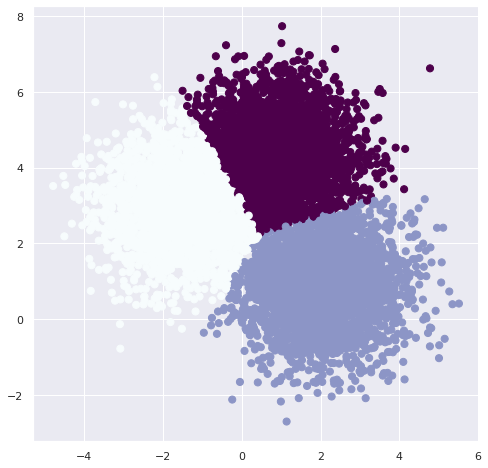

             n_clusters  k
0  KMedoids__n_clusters  3
train 
          Mean       STD
2                      
ARI  0.790246  0.006842
FM   0.860167  0.004548
HCV  0.725355  0.006372
MI   0.725311  0.006350
test 
          Mean       STD
2                      
ARI  0.790099  0.013097
FM   0.860092  0.008771
HCV  0.725465  0.012669
MI   0.725311  0.012627
            jaccard_index       0.7523240167079774
               rand_index       0.9057920509686261
            adjrand_index       0.7880099821438249
    fowlkes_mallows_index       0.8586585695375567
                 fmeasure        0.858658569459476
             purity_index       0.9241111111111111
     classification_error       0.0758888888888889
        czekanowski_index        0.858658569459476
               dice_index        0.858658569459476
           sorensen_index        0.858658569459476
    rogers_tanimoto_index       0.8278061329845582
          southwood_index       3.0375331782611683
      pearson_correlation    2.

In [ ]:
CLUSTER_ALGO = 'KMedoids'
hyper_cluster(CLUSTER_ALGO)